<a href="https://colab.research.google.com/github/scottspurlock/csc4422-s2024/blob/main/demos/day26_demo_gpt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DMML Day 26 Demo: Fine-tuning GPT2
Adapted from: https://colab.research.google.com/drive/13dZVYEOMhXhkXWfvSMVM1TTtUDrT6Aeh?usp=sharing


# Setup

In [ ]:
# !pip install transformers

In [ ]:
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
!nvidia-smi

Mon May  6 11:26:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA TITAN RTX               Off | 00000000:03:00.0  On |                  N/A |
| 41%   32C    P8              16W / 280W |    318MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# run on the gpu if available
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

# GPT2 Tokenizer

In [ ]:
# Load the GPT tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')

/home/scott/anaconda3/envs/torch/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

In [ ]:
prompt = 'The quick brown fox'

tokens = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
tokens = tokens.to(device)

print(tokens)

tensor([[  464,  2068,  7586, 21831]], device='cuda:0')


## Load the pre-trained model

In [ ]:
# instantiate the model
model = GPT2LMHeadModel.from_pretrained('gpt2-medium')
model = model.to(device)

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

## Generate data from pre-trained model

In [ ]:
sample_outputs = model.generate(
                                tokens,
                                do_sample=True,
                                top_k=50,
                                max_length=300,
                                top_p=0.95,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: The quick brown fox jumps the pond... and then the fox jumps a creek. When I was growing up, I never read the newspaper — all I knew was the news."

When I arrived at Texas A&M, my classes ended and my teacher's duties were taken from me. It wasn't until I joined the faculty in the school's College of Communication that I began to explore the different ways in which the media interacts with campus and the media's impact on students' everyday lives. I started working with various media students, from students at nearby schools to graduates of the College of Education in the United States, Mexico, and Venezuela, and worked with reporters from Mexico's La Jornada de America on stories. From there, I began to investigate the ways in which students from different backgrounds might interact and interact with each other through various media sources.

To me, media is like social media; there are some people who use them but most of us just use the network itself. In fact, I became frustrat

## Get some data to fine-tune the model with

In [ ]:
pd.set_option('display.max_colwidth', None)

df = pd.read_csv('https://drive.google.com/uc?export=download&id=19Pw8jY8zRvC2GeFy4Vm_q1e1cnxNhRMA', sep='\t', header=None)

df = df.dropna()

# get rid of short rows
mask = df[0].str.len() > 30
df = df[mask]

df.head()

,0
1,"Before we proceed any further, hear me speak."
5,You are all resolved rather to die than to famish?
9,"First, you know Caius Marcius is chief enemy to the people."
13,"Let us kill him, and we'll have corn at our own price."
16,"No more talking on't; let it be done: away, away!"


In [ ]:
overviews = df.iloc[:5000, 0]
overviews.head()

1                   Before we proceed any further, hear me speak.
5              You are all resolved rather to die than to famish?
9     First, you know Caius Marcius is chief enemy to the people.
13         Let us kill him, and we'll have corn at our own price.
16              No more talking on't; let it be done: away, away!
Name: 0, dtype: object

# PyTorch Datasets & Dataloaders


In [ ]:
# keep batch_size small to avoid running out of memory while training
batch_size = 2

Make a standard PyTorch dataset class
- https://pytorch.org/tutorials/beginner/data_loading_tutorial.html


The dataset class loads the data, tokenizes it, and makes sure each example is the same length by truncating or padding as needed.

Each example gets an attention mask to tell the model to ignore any padding.

More info about the tokenizer:
- https://huggingface.co/transformers/main_classes/tokenizer.html

In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

#### Set up bos, eos, and padding tokens

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')

print(f'The beginning of sequence token {tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id)} token has the id {tokenizer.bos_token_id}')
print(f'The end of sequence token {tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id)} has the id {tokenizer.eos_token_id}')
print(f'The padding token {tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id)} has the id {tokenizer.pad_token_id}')

# instantiate the model
model = GPT2LMHeadModel.from_pretrained('gpt2-medium')

# this step is necessary because we've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))
model = model.to(device)

/home/scott/anaconda3/envs/torch/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [ ]:
dataset = GPT2Dataset(overviews, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f'{train_size:>5,} training samples')
print(f'{val_size:>5,} validation samples')

4,500 training samples
  500 validation samples


In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [ ]:
# model = GPT2LMHeadModel.from_pretrained('gpt2')
# # model.resize_token_embeddings(len(tokenizer))
# device = torch.device("cuda")
# model.cuda()


In [ ]:
epochs = 5
learning_rate = 5e-4
warmup_steps = 100
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/home/scott/anaconda3/envs/torch/lib/python3.11/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            prompt = "<|startoftext|>"
            generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
            generated = generated.to(device)
            sample_outputs = model.generate(
                                generated,
                                do_sample=True,
                                top_k=50,
                                max_length=300,
                                top_p=0.95,
                                num_return_sequences=3
                                )


            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,250. Loss: 0.09373236447572708.   Elapsed: 0:00:48.
0: You are out of your minds.
1: We find our Lord's soul so malign and dangerous.
2: And thou hadst but to bid a good deed to thee: yet that, if not so, should


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,250. Loss: 0.07175108045339584.   Elapsed: 0:01:37.
0: I am a widow.
1: Hath a father from thee; and he is the man I have saved
2: Were no men? If not, do you


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,250. Loss: 0.10796131193637848.   Elapsed: 0:02:26.
0: Thou didst in my nature, how he was set
1: But he can not be killed: so
2: He who might be killed cannot be prevented, but


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,250. Loss: 0.06034395098686218.   Elapsed: 0:03:15.
0: But the king's death to me will be his
1: The state is anvil'd: my own son is in distress,
2: And being then again born, he must have prevented this.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,250. Loss: 0.06765918433666229.   Elapsed: 0:04:06.
0: I'll give you any word but I will not beg from you.
1: More in the name of my wife's son's life;
2: He lives and dies for his children,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,250. Loss: 0.07716090977191925.   Elapsed: 0:04:57.
0: If you must be quiet, I can not
1: Most are unshapen: they do not fight, but
2: The power I have would take you in my arms; you may see


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,250. Loss: 0.0746777281165123.   Elapsed: 0:05:49.
0: Which had most I do and it was not me;
1: That thy good deeds are such as you know them not,
2: To give thy husband to our hands? If thou dost:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,250. Loss: 0.06960932910442352.   Elapsed: 0:06:41.
0: When there heed the house,
1: A widow was born. 'I have sent.'
2: When thou withers away, have let me know of it:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,250. Loss: 0.08264819532632828.   Elapsed: 0:07:33.
0: And then, my good madam: if that's how I love you;
1: And for our general life. O. 'Long enough now,'
2: Thou madst thou; and, thou art a liar!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,250. Loss: 0.07677791267633438.   Elapsed: 0:08:25.
0: And to a great and more grievous city,
1: From the Tower to the Tower, for they are
2: A goodly company for us to see, the king:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,250. Loss: 0.06956779211759567.   Elapsed: 0:09:16.
0: Nor yet was he that is the prince, when he,
1: In these wars and wars as soon as thou art ready
2: Let's go on: for he's unshatter'd,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,250. Loss: 0.049531009048223495.   Elapsed: 0:10:07.
0: My lord, the mayor, he has never
1: You have been as good as your father,
2: And I'll say 'Good Lord Hastings, the cause is 'twere


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,250. Loss: 0.07502692937850952.   Elapsed: 0:10:59.
0: On all the way; O, let me pray you, I'll not be too quick
1: That, as much as I have
2: Withal, to seek but at, that you cannot. When


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,250. Loss: 0.06242255121469498.   Elapsed: 0:11:50.
0: A slave, that so I may prove to your country,
1: And all your dealings with us, and your hate with us,
2: You cannot tell me whether your mother


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,250. Loss: 0.07668064534664154.   Elapsed: 0:12:41.
0: The nobles and citizens of the city;
1: As we are charged for all our enemies' sake,
2: As it is time to see it, my good lord; I shall tell


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,250. Loss: 0.08473613113164902.   Elapsed: 0:13:33.
0: And 'zounds! 'zounds! 'zounds!
1: And that he may not be all these times?
2: What have thou not hear thou. Go see thy lord.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,250. Loss: 0.06727974861860275.   Elapsed: 0:14:24.
0: I was but a boy; I would not play the one
1: O, and his royal presence, I fear,
2: Thou must be put to death for all,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,250. Loss: 0.08184967935085297.   Elapsed: 0:15:15.
0: Than in such a time as for you come;
1: Runes and gates have been used
2: They should do well to the good of the people:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,250. Loss: 0.07440311461687088.   Elapsed: 0:16:07.
0: As it is, he of the senate and patricians have;
1: If he be the boar's enemy, what's he?
2: Which that cannot be but by virtue


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,250. Loss: 0.07086797058582306.   Elapsed: 0:16:59.
0: Why, it is almost in time for the chamber.
1: Were you so; but I am prepared,
2: What are, to say the truth? There's noisome duke, he hath


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,250. Loss: 0.07516961544752121.   Elapsed: 0:17:52.
0: I think you'll hear of me. This boar is almost an officer's son.
1: To see me; but what I may be content,
2: They cry you 'Raveer.' 'Sid.' 'Whose 'Whose.' 'Lark.' 'M.' '


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  2,250. Loss: 0.05811566114425659.   Elapsed: 0:18:44.
0: When he had gone. The most advanced he is,
1: A little fear, to make it more fair and easy
2: Hast a warrant for your son, who is a good thing

  Average training loss: 0.08
  Training epoch took: 0:19:10

Running Validation...
  Validation Loss: 0.07
  Validation took: 0:00:39

======== Epoch 2 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,250. Loss: 0.04431496933102608.   Elapsed: 0:00:53.
0: Which now you could never have done. I think I'd have been
1: He never had this high thing so as much as what he show'd.
2: To me I do it secretly. When I think, I tell myself,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,250. Loss: 0.04304042458534241.   Elapsed: 0:01:44.
0: Thinking, when he was once perforce sworn
1: Held me in chase, my lord; a fearful deed.
2: To him that has sent us to Rome, we,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,250. Loss: 0.05632239207625389.   Elapsed: 0:02:35.
0: O, if he give me, go in, thou shall bear a head for ten thousand of throats
1: Let him deny my purpose, and, if he,
2: No, at a word for 'em. I would never.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,250. Loss: 0.04145130515098572.   Elapsed: 0:03:27.
0: As the duke of Gloucester, my uncle York,
1: The nobles were against their dastard designs,
2: He, and all his brethren, and his brother


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,250. Loss: 0.05495060607790947.   Elapsed: 0:04:18.
0: What do you speak? is your name Menenius?
1: The mayor of England, a fellow-tribune
2: But have done what thou hast done?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,250. Loss: 0.07092662900686264.   Elapsed: 0:05:09.
0: To make him do so now.
1: What you are, brother and friends, our friends:
2: I'd rather had my life on a soldier's head,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,250. Loss: 0.05790674313902855.   Elapsed: 0:06:01.
0: That could crush the Volsces; and I will no further
1: But by many a word didst thou speak?
2: No doubt; I cannot reason in the very absence.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,250. Loss: 0.07012048363685608.   Elapsed: 0:06:52.
0: Marry, why, so? he killed me;
1: And, as I say, do not have me leave to take
2: The Volsces that are ruled by Aufidius:--and are ruled


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,250. Loss: 0.07108175754547119.   Elapsed: 0:07:44.
0: Have I been as we'll prove friends, I would:
1: But, they, and us, have all our thanks:
2: Which you have in the presence o' the king.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,250. Loss: 0.05749174952507019.   Elapsed: 0:08:35.
0: To stop my mother and England's king.
1: He will be sworn between a cudgel and a cudgel,
2: If they do not deserve our voices, then they


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,250. Loss: 0.0625932365655899.   Elapsed: 0:09:26.
0: To-morrow--I must away from thence;
1: If you should have been so hard-dispersing.
2: My dream is lengthen'd to an end;


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,250. Loss: 0.06757303327322006.   Elapsed: 0:10:18.
0: He is grown not to a full-out of his limbs,
1: And, good my lord, you stand on me:
2: Was ever woman in Christendom


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,250. Loss: 0.06020773574709892.   Elapsed: 0:11:09.
0: With all this while your party
1: To make all his fair limbs work
2: The same time our fellows are at liberty.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,250. Loss: 0.05084012821316719.   Elapsed: 0:12:00.
0: 'Tis time to come; but, in this good request,
1: A bribe-out of the people? then, if you'll come,
2: 'Tis almost all the more dangerous


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,250. Loss: 0.058352358639240265.   Elapsed: 0:12:51.
0: Than in his own person. Therefore pardon his son.
1: What do you think, brother? what's to be?
2: And set a cotch of your high deserts:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,250. Loss: 0.06373979151248932.   Elapsed: 0:13:43.
0: How well are we, sir? 'Tis no more at home now:
1: You are all but safe; but there come the king.
2: If they should shake off the debt which they lent us,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,250. Loss: 0.050359055399894714.   Elapsed: 0:14:34.
0: Than in the coldest you can imagine
1: A very fair cousin, sir.
2: With the same authority, but by the means.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,250. Loss: 0.05410483106970787.   Elapsed: 0:15:25.
0: He knows nothing, is not content for the people,
1: I know you you, and have deserved your hate,
2: In that, as I live, I hope he'll not stay;


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,250. Loss: 0.050967149436473846.   Elapsed: 0:16:16.
0: Or that my sword should fright my heart,
1: And, the nobles dally before her,
2: In your person, when I was on guard:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,250. Loss: 0.05400988459587097.   Elapsed: 0:17:07.
0: But as I did have been made your enemy by
1: My noble cousin Buckingham had I need of;
2: Or none could cure their decay byOur general!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,250. Loss: 0.0596691332757473.   Elapsed: 0:17:58.
0: The man is well meted; he's well meted:
1: As we had rather give: let us be done
2: Your voices seem to be less virtuous than yours,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  2,250. Loss: 0.06094884127378464.   Elapsed: 0:18:49.
0: And when we will see, we will not need to put it.
1: The great power and great power, the great power--
2: When I shall have struck; it is not that easy,

  Average training loss: 0.06
  Training epoch took: 0:19:15

Running Validation...
  Validation Loss: 0.08
  Validation took: 0:00:39

======== Epoch 3 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,250. Loss: 0.03505721315741539.   Elapsed: 0:00:51.
0: But I'll turn her in her extremest extremity,
1: And bid them all away. My lord, I bid him away.
2: Let me have cushions by you. Fare you well, and give me leave;


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,250. Loss: 0.03014567494392395.   Elapsed: 0:01:42.
0: More direful sentence: ere the king
1: Good morrow, Catesby; you voices have kept your information in your
2: Howbeit, I think; and I do have some cause to think it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,250. Loss: 0.05169358104467392.   Elapsed: 0:02:34.
0: My pretty cousins, have we laid in the field?
1: Hark what noise they have! why noise! they!
2: I'll show some new tricks which you teach me how to flatter


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,250. Loss: 0.034950509667396545.   Elapsed: 0:03:25.
0: That seem less virtuous than those
1: And make it brief. First, if I were
2: Thy beauty hath, and made them blind with weeping.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,250. Loss: 0.038618218153715134.   Elapsed: 0:04:16.
0: I shall be as rash. Yet do I give it gentle?
1: It is thought of every one of us to be
2: He that bereft thee, that loves thee so.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,250. Loss: 0.038790263235569.   Elapsed: 0:05:07.
0: If you should not suffer these tedious days,
1: The manner and purpose of his treason;--
2: Whose repetition shall be dogg'd with curses.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,250. Loss: 0.04157128930091858.   Elapsed: 0:05:58.
0: The best of us, that are not worth predecessors,
1: And make my misery serve no further.
2: If they be senators: and they have senators,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,250. Loss: 0.03626686707139015.   Elapsed: 0:06:49.
0: A noble memory-pot; now, princely Buckingham,
1: When that we did call the nettle nettle but nettle nettle nettle,
2: A knot you are damned devil! O bloody devil!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,250. Loss: 0.042136043310165405.   Elapsed: 0:07:40.
0: What makes thy misery? it is as easy
1: The kindred of the queen;
2: A blessed and a joyful time of day!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,250. Loss: 0.06091562658548355.   Elapsed: 0:08:31.
0: He's a parlous boy; go, go, I say, he is too shrewd.
1: O, to give way the while some tormenting dream!
2: And that the commoners, for whom we stand, but they


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,250. Loss: 0.04698997363448143.   Elapsed: 0:09:23.
0: Or let us stand to our authority,
1: I am in your debt for your last exercise,
2: As well as speak--it would have gall'd him


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,250. Loss: 0.0428483709692955.   Elapsed: 0:10:14.
0: Than my husband's answer to me: he replied
1: But I will not have the hearts to do't,
2: As much as in his outward actions shows itself in love


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,250. Loss: 0.04581761732697487.   Elapsed: 0:11:05.
0: That's as hard as thou would. Fix me, then repair.
1: The commoners, not the nobility, hath bid the world good night:
2: Away, my boy. I pray, I am gone.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,250. Loss: 0.03030409850180149.   Elapsed: 0:11:56.
0: With no less honour to their wives and boys:
1: To stop devoted charitable deeds? To stop devoted charitable deeds?
2: You never stood upright in any cause,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,250. Loss: 0.04941365495324135.   Elapsed: 0:12:47.
0: O, be it so, O, be it so. Assist.
1: Be this they who brought thee to this world.
2: That by his red colour hath forsook his cheeks;


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,250. Loss: 0.04774826392531395.   Elapsed: 0:13:39.
0: In this soothed not on it; and, in love and zeal,
1: 'Tis not that we shall request any good,
2: I would not have given my uncle's grace a flout:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,250. Loss: 0.04092288389801979.   Elapsed: 0:14:30.
0: For the instalment of the noble duke
1: That's not the way to lay the city flat;
2: Which they have not yet tread on their hearts,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,250. Loss: 0.035239215940237045.   Elapsed: 0:15:21.
0: I am the queen thereof; the honour'd gods give you joy;
1: And now the dead bones of eagles
2: In him and that shall be consul in the name


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,250. Loss: 0.055747140198946.   Elapsed: 0:16:13.
0: We'll have letters here; tell us what you say,
1: O Margaret Margaret Margaret Margaret Margaret Margaret Margaret Margaret Margaret Margaret Margaret Margaret Margaret Margaret Margaret Margaret Margaret Margaret Margaret Margaret Margaret
2: And will be revenged on him where he should be.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,250. Loss: 0.04183527082204819.   Elapsed: 0:17:04.
0: I' the way of flattery further.
1: My sovereign liege, I tell you what: if all the prince
2: But, he that trusts to you cannot tell me more


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,250. Loss: 0.04112638905644417.   Elapsed: 0:17:55.
0: And I will be consul of that: you are
1: Of his own royal self: what's your grace?
2: A little of his worthy work perform'd;


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  2,250. Loss: 0.06516402959823608.   Elapsed: 0:18:47.
0: For in his country's name, let him know your name:
1: When first I was a little peevish boy.
2: That my young nobility did rise;

  Average training loss: 0.04
  Training epoch took: 0:19:12

Running Validation...
  Validation Loss: 0.08
  Validation took: 0:00:39

======== Epoch 4 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,250. Loss: 0.023833440616726875.   Elapsed: 0:00:51.
0: As if thyself's safety was a necessary
1: To do a good day's work, you should do,
2: His rougher accents for malicious sounds,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,250. Loss: 0.02021295763552189.   Elapsed: 0:01:42.
0: Come, my lord, have you any courtesy show'd?
1: And says that there is no more but peace is
2: Come, come, come, we know not what to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,250. Loss: 0.023340871557593346.   Elapsed: 0:02:34.
0: Or else it would have gall'd his surly nature,
1: God grant we never may have need of you!
2: But, by despairing them, you shouldst be


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,250. Loss: 0.021875590085983276.   Elapsed: 0:03:25.
0: What we will do, if we perceive
1: O monstrous, monstrous! thou know'st the devil.
2: To the Volsces! Coriolanus!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,250. Loss: 0.01737169921398163.   Elapsed: 0:04:16.
0: That in these five years together I have lost--
1: And what is he that is my husband?
2: I pray you, uncle, give me this dagger.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,250. Loss: 0.022583957761526108.   Elapsed: 0:05:08.
0: I'll turn yon fellow in his grave, and send him to the Tower.
1: To the people; not by your own instruction,
2: Bid me farewell, and smile. I pray you, come.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,250. Loss: 0.029895508661866188.   Elapsed: 0:05:59.
0: Whilst Aufidius, Caius Marcius,
1: Your stinking greasy in mine ears,
2: You know me, Marcius, is not in the vein


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,250. Loss: 0.023528089746832848.   Elapsed: 0:06:51.
0: For this will out, and here I must not stay.
1: But now two mirrors of his princely semblance
2: And so I take it. I am one that, sir,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,250. Loss: 0.023435495793819427.   Elapsed: 0:07:42.
0: We will see, sir, a thousand fearful wrecks;
1: Who's in my stead: the waters in the sun
2: As thou dost swallow'd it: with thy hand I seal thy true heart's love


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,250. Loss: 0.02056540921330452.   Elapsed: 0:08:33.
0: What you have seen him do and heard him speak,
1: To banish a friend, to eject me hence,
2: How doth he stand affected to our purpose?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,250. Loss: 0.018568886443972588.   Elapsed: 0:09:25.
0: As loath to lose him, not your father's death;
1: And for my life, I wonder if I had not thought.
2: But I know none. My mother bows;


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,250. Loss: 0.024769283831119537.   Elapsed: 0:10:16.
0: He cannot tell who caused his father's death,
1: Why did you hear the lamentations of Poor Anne?
2: And so once more I did return that promise--


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,250. Loss: 0.029903005808591843.   Elapsed: 0:11:07.
0: Withal obdurate, untimely brought to light,
1: Take thy office from thee to the people;
2: Even as these shows, my lord, were you suppose,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,250. Loss: 0.03459358215332031.   Elapsed: 0:11:59.
0: The tribunes for his country are requited,
1: Have made them mules, silenced their pleaders and
2: The gods will revenge it, and the people


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,250. Loss: 0.019632311537861824.   Elapsed: 0:12:50.
0: Now with a grain a day, I would not buy
1: Where you shall find me well accompanied
2: I am their fathers mother; I will see them both.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,250. Loss: 0.021603478118777275.   Elapsed: 0:13:41.
0: My wife hath nor honesty nor grace. Therefore, good people,--
1: And we will pamper it with lamentations.
2: To banish Aufidius 'head;' and he Romans,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,250. Loss: 0.01818348839879036.   Elapsed: 0:14:33.
0: For which in all this presence speaks your grace?
1: He and Aufidius are at the one;
2: Of all the trades in Rome. Look, I say, I would not


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,250. Loss: 0.020610645413398743.   Elapsed: 0:15:24.
0: Our aery buildeth in your aery's nest.
1: Who knows not that the noble duke is dead?
2: His answer was, the people were not wont


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,250. Loss: 0.029563436284661293.   Elapsed: 0:16:15.
0: You are too senseless--obstinate, if it were light enough.
1: Behold, a book of prayer in his hand,
2: I will not have intelligence to speak


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,250. Loss: 0.034127362072467804.   Elapsed: 0:17:07.
0: My uncle Rivers talk'd how I did grow
1: I have forgot my part, and I am out,
2: Who will I make before I let thee go.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,250. Loss: 0.02165374346077442.   Elapsed: 0:17:58.
0: In congregations, to yawn, be still and wonder,
1: And then hurl down their indignation
2: But if you were a slave, or your own death,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  2,250. Loss: 0.03182494640350342.   Elapsed: 0:18:49.
0: How more unfortunate than all living women
1: The noble father of our Lord of York! O, the son!
2: What is the news? what news? what news?

  Average training loss: 0.02
  Training epoch took: 0:19:15

Running Validation...
  Validation Loss: 0.10
  Validation took: 0:00:39

======== Epoch 5 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,250. Loss: 0.013578733429312706.   Elapsed: 0:00:51.
0: If thou increase his evil, increase his evil;
1: Wherein this trunk was framed, and in her hand
2: He cannot choose. I am most fortunate, thus


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,250. Loss: 0.01588723622262478.   Elapsed: 0:01:42.
0: We have been called so of many; not all so
1: Which we disdain should tatter us, yet sought
2: As you were fore-advised, had touch'd his spirit


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,250. Loss: 0.013822167180478573.   Elapsed: 0:02:33.
0: We are the greater poll, and in true fear
1: Than crave the hire which first we do deserve.
2: We pout upon the morning, are unapt


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,250. Loss: 0.015963252633810043.   Elapsed: 0:03:25.
0: We have a power on foot; and I had purpose
1: When he did stand for consul, which he lost
2: No, to White-Friars; there attend my coining.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,250. Loss: 0.015628207474946976.   Elapsed: 0:04:16.
0: If thou delight to view thy heinous deeds,
1: What, dost thou scorn me for my gentle counsel?
2: You are sent for to the Capitol. 'Tis thought


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,250. Loss: 0.01320668961852789.   Elapsed: 0:05:07.
0: For the instalment of this noble duke
1: That's sure of death without it, at once pluck out
2: He was to begin and give away


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,250. Loss: 0.014776433818042278.   Elapsed: 0:05:58.
0: To pray for them that have done scathe to us.
1: And the most merciless that e'er was heard of!
2: What cause soever, in this our after-meeting,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,250. Loss: 0.014988873153924942.   Elapsed: 0:06:50.
0: You, that do object the same to him;
1: Why, hark you the noise that banish'd him?
2: Withal I did infer your lineaments,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,250. Loss: 0.016906552016735077.   Elapsed: 0:07:41.
0: Hath in eternal darkness folded up.
1: The time will come when thou shalt wish for me
2: Than shame to our Romans: and we here deliver,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,250. Loss: 0.016745008528232574.   Elapsed: 0:08:32.
0: Thou art their soldier, and being bred in broils
1: His master's son, as worshipful as he terms it,
2: But what's the matter, Clarence?  may I know?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,250. Loss: 0.01440624799579382.   Elapsed: 0:09:23.
0: With a drum, a drum, a drum, and
1: His master's son, as worshipful as he terms it,
2: Tent in my cheeks, and schoolboys' tears take up


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,250. Loss: 0.015153178945183754.   Elapsed: 0:10:15.
0: I long with all my heart to see the prince:
1: No way from yourselves. What do you think,
2: How say you sir? Can you deny all this?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,250. Loss: 0.016729557886719704.   Elapsed: 0:11:06.
0: And presently, when you have drawn your number,
1: We have not yet set down this day of triumph.
2: Our dear Redeemer, we must not


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,250. Loss: 0.013561655767261982.   Elapsed: 0:11:57.
0: What stays had we but Clarence? and he's gone.
1: Your beauty: which did haunt me in my sleep
2: My lord, with all despite; notwithstanding that,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,250. Loss: 0.013673834502696991.   Elapsed: 0:12:48.
0: With bloody passage led your wars even to
1: Why, madam, you three, on me, threefold distress'd,
2: I'll go meet the ladies. This Volumnia


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,250. Loss: 0.014394824393093586.   Elapsed: 0:13:40.
0: What black magician conjures up this fiend,
1: With those that have the wit to claim the place:
2: In sign of league and amity with thee:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,250. Loss: 0.014842750504612923.   Elapsed: 0:14:31.
0: He that will be won to a better husband than
1: Where is your ancient courage? you were used
2: The people mutinous; and it is rumour'd,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,250. Loss: 0.014317634515464306.   Elapsed: 0:15:22.
0: In my opinion, ought to be prevented.
1: But you shall be new-christen'd in the Tower.
2: He has neither claim'd it nor deserved it; for


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,250. Loss: 0.019634775817394257.   Elapsed: 0:16:13.
0: Forgive my tyranny; but do not say
1: By circumstance, but to thy cursed self.
2: If they do hold the same intent wherein


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,250. Loss: 0.015451528131961823.   Elapsed: 0:17:04.
0: Than pity to our prayers. Down: an end;
1: He proved best man i' the field, and for his meed
2: The time will come when thou shalt wish for me


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,250. Loss: 0.0142725994810462.   Elapsed: 0:17:56.
0: And that, to cut off those that have offended him?
1: Thou liest: and thy great father Warwick
2: Why, so: now have I done a good day's work:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  2,250. Loss: 0.016001665964722633.   Elapsed: 0:18:47.
0: A hundred thousand welcomes. I could weep
1: The news is, sir, the Volsces are in arms.
2: My friends of noble touch, when I am forth,

  Average training loss: 0.02
  Training epoch took: 0:19:13

Running Validation...
  Validation Loss: 0.12
  Validation took: 0:00:39

Training complete!
Total training took 1:39:20 (h:mm:ss)


Let's view the summary of the training process.

In [ ]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.080258,0.072329,0:19:10,0:00:39
2,0.058971,0.075096,0:19:15,0:00:39
3,0.042026,0.083113,0:19:12,0:00:39
4,0.024382,0.097625,0:19:15,0:00:39
5,0.015508,0.115535,0:19:13,0:00:39


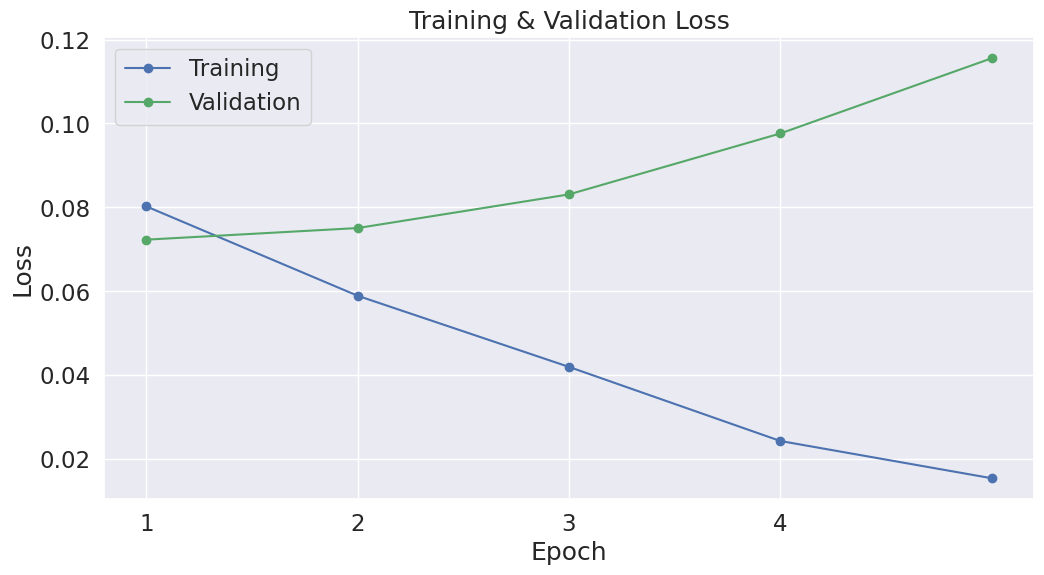

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Saving & Loading Fine-Tuned Model


In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f'Saving model to {output_dir}')

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [ ]:
!ls -l --block-size=K ./model_save/

total 1387512K
-rw-rw-r-- 1 scott scott       1K May  6 13:31 added_tokens.json
-rw-rw-r-- 1 scott scott       1K May  6 13:30 config.json
-rw-rw-r-- 1 scott scott       1K May  6 13:30 generation_config.json
-rw-rw-r-- 1 scott scott     446K May  6 13:31 merges.txt
-rw-rw-r-- 1 scott scott 1386066K May  6 13:31 model.safetensors
-rw-rw-r-- 1 scott scott       1K May  6 13:31 special_tokens_map.json
-rw-rw-r-- 1 scott scott       1K May  6 13:31 tokenizer_config.json
-rw-rw-r-- 1 scott scott     976K May  6 13:31 vocab.json


## For this example, we'll just zip up the folder
Then the zip file can be downloaded manually.

A better idea might be to connect your notebook to your Google Drive and save the file there automatically.

In [ ]:
# zip up the folder
!zip -rv gpt2_model.zip ./model_save/

  adding: model_save/	(in=0) (out=0) (stored 0%)
  adding: model_save/vocab.json 	(in=999186) (out=319813) (deflated 68%)
  adding: model_save/merges.txt 	(in=456318) (out=213309) (deflated 53%)
  adding: model_save/generation_config.json	(in=119) (out=90) (deflated 24%)
  adding: model_save/added_tokens.json	(in=51) (out=41) (deflated 20%)
  adding: model_save/config.json	(in=967) (out=461) (deflated 52%)
  adding: model_save/tokenizer_config.json	(in=873) (out=261) (deflated 70%)
  adding: model_save/model.safetensors .......................................................................................................................................	(in=1419331072) (out=1317878944) (deflated 7%)
  adding: model_save/special_tokens_map.json	(in=579) (out=128) (deflated 78%)
total bytes=1420789165, compressed=1318413047 -> 7% savings


## Restoring saved model

In [ ]:
# unzip
# !unzip gpt2_model.zip

# Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

# Generate Text

In [ ]:
model.eval()

prompt = 'hark'
generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated,
                                do_sample=True,
                                top_k=100,
                                max_length = 800,
                                top_p=0.95,
                                num_return_sequences=5,
                                pad_token_id=tokenizer.eos_token_id
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


0: harkens on him, and scorns him; even so most assured


1: harkens and noise be our instruction.


2: harkens the morning, and the noon-tide night.


3: harkens after prophecies and dreams;


4: harkens and noise o' the monster's, wants not spirit


